In [2]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip -q household_power_consumption.zip

replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
!pip install -q keras
!pip install -q tqdm

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
%matplotlib inline
import math
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

Using TensorFlow backend.


In [5]:
df = pd.read_csv("household_power_consumption.txt", sep = ";")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df[(df.Global_active_power!="?")]

In [0]:
df["Timestamp"] = df["Date"].astype(str)+" "+df["Time"]

In [0]:
df.Timestamp = pd.to_datetime(df.Timestamp, format = "%d/%m/%Y %H:%M:%S")

In [0]:
df.Date = pd.to_datetime(df.Date, format = "%d/%m/%Y")

In [0]:
df.Global_active_power = df.Global_active_power.astype(float)
df.Global_reactive_power = df.Global_reactive_power.astype(float)
df.Voltage = df.Voltage.astype(float)
df.Sub_metering_1 = df.Sub_metering_1.astype(float)
df.Sub_metering_2 = df.Sub_metering_2.astype(float)
df.Sub_metering_3 = df.Sub_metering_3.astype(float)

In [0]:
day1 = df[(df.Date == "2007-02-01")]

(array([732707.95833333, 732708.08333333, 732708.20833333, 732708.33333333,
        732708.45833333, 732708.58333333, 732708.70833333, 732708.83333333,
        732708.95833333]), <a list of 9 Text xticklabel objects>)

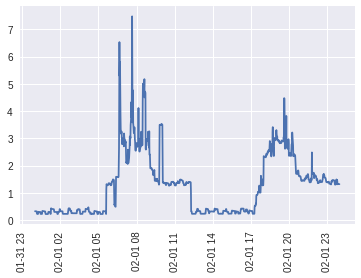

In [12]:
# plt.figure(figsize=(8,8))
plt.plot(day1['Timestamp'], day1['Global_active_power'])
plt.xticks(rotation='vertical')

(array([732708.95833333, 732709.08333333, 732709.20833333, 732709.33333333,
        732709.45833333, 732709.58333333, 732709.70833333, 732709.83333333,
        732709.95833333]), <a list of 9 Text xticklabel objects>)

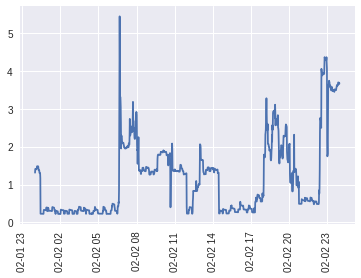

In [13]:
day2 = df[(df.Date == "2007-02-02")]
# plt.figure(figsize=(4))
plt.plot(day2['Timestamp'], day2['Global_active_power'])
plt.xticks(rotation='vertical')

(array([733074.95833333, 733075.08333333, 733075.20833333, 733075.33333333,
        733075.45833333, 733075.58333333, 733075.70833333, 733075.83333333,
        733075.95833333]), <a list of 9 Text xticklabel objects>)

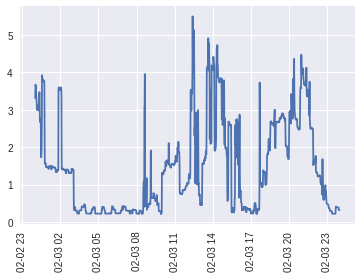

In [14]:
day3 = df[(df.Date == "2008-02-03")]
# plt.figure(figsize=(4))
plt.plot(day3['Timestamp'], day3['Global_active_power'])
plt.xticks(rotation='vertical')

(array([732646., 732828., 733011., 733194., 733377., 733559., 733742.,
        733924., 734107.]), <a list of 9 Text xticklabel objects>)

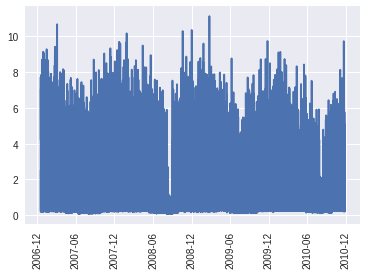

In [15]:
# day2 = df[(df.Date == "2007-02-02")]
# plt.figure(figsize=(4))
plt.plot(df['Timestamp'], df['Global_active_power'])
plt.xticks(rotation='vertical')

In [0]:
dataset = df.Global_active_power
dataset = np.asarray(dataset)

In [17]:
dataset.shape

(2049280,)

In [0]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
# train_size = int(len(dataset) * 0.98)
# test_size = int((len(dataset) - train_size) * 0.5)
# valid_size = len(dataset) - train_size - test_size
# train, test = dataset[0:train_size], dataset[train_size:]
# train_x, train_y = create_dataset(train,window_size)

seq_len = 50
# batch_size = 32
sequence_length = seq_len + 1
result = []
for index in range(len(dataset) - sequence_length):
    result.append(dataset[index: index + sequence_length])

result = np.array(result)

train_size = int(len(dataset) * 0.98)
test_size = int((len(dataset) - train_size) * 0.5)
valid_size = len(dataset) - train_size - test_size
train = result[:int(train_size), :]
x_train = train[:, :-1]
y_train = train[:, -1]

x_valid = result[int(train_size):int(train_size) + valid_size, :-1]
y_valid = result[int(train_size):int(train_size) + valid_size, -1]

x_test = result[int(train_size) + valid_size:, :-1]
y_test = result[int(train_size) + valid_size:, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

In [19]:
x_train.shape

(2008294, 50, 1)

In [20]:
x_valid.shape

(20493, 50, 1)

In [21]:
x_test.shape

(20442, 50, 1)

In [0]:
class DataGenerator(object):
    def __init__(self, batch_size = 32, shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, x, y):
        while 1:
        
            imax = int(len(x)/self.batch_size)
            for i in range(imax):
                inp = x[i*batch_size:(i+1)*batch_size]
                out = y[i*batch_size:(i+1)*batch_size]
                yield inp, out

In [0]:
batch_size = 10000
params = {'batch_size': 10000,
          'shuffle': True}

training_generator = DataGenerator(**params).generate(x_train, y_train)
validation_generator = DataGenerator(**params).generate(x_valid, y_valid)


# LSTM

In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(seq_len, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience = 5)

In [26]:
model.fit_generator(generator = training_generator,
                    steps_per_epoch = len(x_train)//batch_size,
                    validation_data = validation_generator,
                    validation_steps = len(x_valid)//batch_size, epochs = 20, callbacks = [earlyStopping], shuffle = True)

Epoch 1/20
200/200 [==============================] - 224s 1s/step - loss: 0.2328 - val_loss: 0.0993
Epoch 2/20
200/200 [==============================] - 221s 1s/step - loss: 0.1034 - val_loss: 0.0752
Epoch 3/20
172/200 [========================>.....] - ETA: 30s - loss: 0.0964

200/200 [==============================] - 221s 1s/step - loss: 0.0913 - val_loss: 0.0690
Epoch 4/20
200/200 [==============================] - 222s 1s/step - loss: 0.0864 - val_loss: 0.0741
Epoch 5/20
200/200 [==============================] - 222s 1s/step - loss: 0.0839 - val_loss: 0.0684
Epoch 6/20
 27/200 [===>..........................] - ETA: 3:11 - loss: 0.1231

200/200 [==============================] - 222s 1s/step - loss: 0.0821 - val_loss: 0.0633
Epoch 7/20
200/200 [==============================] - 222s 1s/step - loss: 0.0809 - val_loss: 0.0737
Epoch 8/20
200/200 [==============================] - 222s 1s/step - loss: 0.0793 - val_loss: 0.0678
Epoch 9/20
  1/200 [..............................] - ETA: 3:38 - loss: 0.2782

200/200 [==============================] - 222s 1s/step - loss: 0.0784 - val_loss: 0.0653
Epoch 10/20
200/200 [==============================] - 221s 1s/step - loss: 0.0776 - val_loss: 0.0666
Epoch 11/20
194/200 [============================>.] - ETA: 6s - loss: 0.0769

200/200 [==============================] - 222s 1s/step - loss: 0.0766 - val_loss: 0.0643


In [0]:
model.save('model_1.h5')

In [28]:
ls

datalab/                         household_power_consumption.zip
household_power_consumption.txt  model_1.h5


In [0]:
from google.colab import files

files.download('model_1.h5')

In [0]:
y_pred = model.predict(x_test)

In [31]:
y_pred.shape

(20442, 1)

In [32]:
y_test.shape

(20442,)

In [33]:
mean_squared_error(y_test, y_pred)

0.060738327118884036

In [34]:
y_pred

array([[1.1838888],
       [0.9967358],
       [1.0262258],
       ...,
       [0.8953949],
       [0.890748 ],
       [0.8822197]], dtype=float32)

In [35]:
y_test

array([1.096, 1.08 , 1.074, ..., 0.944, 0.938, 0.934])

## RANDOM FOREST

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1])) 

In [0]:
regr = RandomForestRegressor(max_depth=6,random_state=0)

In [41]:
regr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
y_pred_rf = regr.predict(x_test)

In [43]:
y_pred_rf

array([1.26283422, 1.05560986, 1.04487351, ..., 0.91565229, 0.91565229,
       0.91565229])

In [44]:
mean_squared_error(y_test, y_pred_rf)

0.04811624515978815

In [25]:
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

NameError: ignored

# Ensemble of LSTM and Random Forest

In [0]:
avg_pred = np.mean([y_pred, y_pred_rf], axis=0)

In [53]:
mean_squared_error(y_test, avg_pred)

0.05007202946038916

In [46]:
y_pred.shape

(20442, 1)

In [48]:
y_test.shape

(20442,)

In [49]:
y_pred_rf.shape

(20442,)

# SVM

In [0]:
train_svm = x_train[:10000]

In [0]:
y_train_svm = y_train[:10000]

In [0]:
clf = SVR()
clf.fit(train_svm, y_train_svm) 

In [0]:
y_pred_svm = clf.predict(x_test)

In [29]:
mean_squared_error(y_test, y_pred_svm)

0.07910799786626199